# This CODE is WORKING Properly and used to extract EEG and ECG | December, 2022

In [ ]:
#  Remember you need to indicate which subject to process
!pip install pyxdf
!pip install mne
!pip install neurokit2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 32.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 38.6 MB/s 


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import pyxdf
import numpy as np
import pandas as pd
import mne
from mne.preprocessing import (ICA, corrmap)
import neurokit2 as nk
# from calibration import calibrate_gsrppg, calibrate_ecg, calibrate_temperature, get_shimmer_data, calibrate_emg

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score

import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Qt5Agg')
%matplotlib

Using matplotlib backend: <object object at 0x000001EE32CA6800>


In [2]:
participant = 1
session = 1
run = 1
task = 'nback_clinical' 
# task = 'suture'
xdf_filename = '/content/drive/MyDrive/Gall_Bladder_Study/Subject_10/Input_files/' \
           'sub-P00' + str(participant) + '_ses-S00' + str(session) + '_task-' + task + '_run-00' + str(run) + '_multi.xdf'

# xdf_filename = '/content/drive/MyDrive/Extrinsic_Study/lsl/sub-P001/ses-S001/multi/' \
#            'sub-P00' + str(participant) + '_ses-S00' + str(session) + '_task-' + task + '_run-00' + str(run) + '_multi.xdf'
# /content/drive/MyDrive/Extrinsic_Study/lsl/sub-P001/ses-S001/multi/sub-P001_ses-S001_task-suture_run-001_multi.xdf

# streams, header = pyxdf.load_xdf(xdf_filename, synchronize_clocks=False, dejitter_timestamps=False)
xdf_filename = "E:\OneDrive - Imperial College London\Individual Project\ProjectCode\Dataset\lsl\sub-P001\ses-S001\multi\sub-P001_ses-S001_task-nback_clinical_run-001_multi.xdf"
xdf_filename = "G:\Code_Multimodal_Deep_learning\Data\Testing004\sub-P004_ses-S001_task-nback_clinical_run-001_multi.xdf"
xdf_filename =  "G:\\Code_Multimodal_Deep_learning\Data\\Testing010\\ses-S001\\multi\\sub-P001_ses-S001_task-nback_clinical_run-001_multi.xdf"
# /content/drive/MyDrive/Gall_Bladder_Study/Subject_1/sub-P001_ses-S001_task-nback_clinical_run-001_multi.xdf

In [3]:
streams, header = pyxdf.load_xdf(xdf_filename, synchronize_clocks=False, dejitter_timestamps=True)
# xdf_filename

In [5]:
print(streams[8]['time_series'])

IndexError: list index out of range

In [4]:
import pandas as pd
import pyxdf
# import json
import numpy as np
# from lib import read_yaml_config
import matplotlib.pyplot as plt


def calibrate_gsrppg(df):
    gsr_cal = []
    ppg_cal = []
    gsr_range = []
    for index, row in df.iterrows():
        # get current GSR range resistor value
        GSR_raw = int(row['gsr_raw'])
        PPG_raw = int(row['ppg'])
        Range = ((GSR_raw >> 14) & 0xff)  # upper two bits
        if (Range == 0):
            Rf = 40.2  # kohm
        elif (Range == 1):
            Rf = 287.0  # kohm
        elif (Range == 2):
            Rf = 1000.0  # kohm
        elif (Range == 3):
            Rf = 3300.0  # kohm

        # convert GSR to kohm value
        gsr_to_volts = (GSR_raw & 0x3fff) * (3.0 / 4095.0)
        GSR_ohm = Rf / ((gsr_to_volts / 0.5) - 1.0)


        # convert PPG to milliVolt value
        PPG_mv = PPG_raw * (3000.0 / 4095.0)

        gsr_cal.append(GSR_ohm)
        ppg_cal.append(PPG_mv)
        gsr_range.append(Range)

    df = df.assign(gsr_range = gsr_range, gsr_cal_kohm = gsr_cal, ppg_cal_mv = ppg_cal)
    return df


# Lead I (LA-RA): ExG1 Ch2
# Lead II (LL-RA): ExG1 Ch1
# Lead III: Lead I - Lead II
# Vx-WCT: ExG2 Ch2
def calibrate_ecg(df):
    # ecg1_status = df['ecg1_status']
    # ecg2_status = df['ecg2_status']

    # ADS Sensitivity
    adc_sen = 2420 / ((2 ** 23) - 1)

    # define
    ecg_la_ra_cal = []
    ecg_ll_ra_cal = []
    resp_cal = []
    ecg_vx_rl_cal = []
    # ADC offset measurement
    for index, row in df.iterrows():
        raw_ecg_la_ra = row['ecg1_ch2']
        raw_ecg_ll_ra = row['ecg1_ch1']
        raw_resp = row['ecg2_ch1']  # respiration
        raw_ecg_vx_rl = row['ecg2_ch2']

        ecg_la_ra_to_mv = ((raw_ecg_la_ra - 0) * adc_sen) / 4
        ecg_ll_ra_to_mv = ((raw_ecg_ll_ra - 0) * adc_sen) / 4
        resp_to_mv = ((raw_resp - 0) * adc_sen) / 4
        ecg_vx_rl_to_mv = ((raw_ecg_vx_rl - 0) * adc_sen) / 4




        ecg_la_ra_cal.append(ecg_la_ra_to_mv)
        ecg_ll_ra_cal.append(ecg_ll_ra_to_mv)
        resp_cal.append(resp_to_mv)
        ecg_vx_rl_cal.append(ecg_vx_rl_to_mv)


    df = df.assign(ecg_la_ra_cal_mv=ecg_la_ra_cal, ecg_ll_ra_cal_mv=ecg_ll_ra_cal, resp_cal_mv=resp_cal, ecg_vx_rl_cal_mv=ecg_vx_rl_cal)
    return df


# emg
def calibrate_emg(df):

    # ADS Sensitivity
    adc_sen = 2420 / ((2 ** 23) - 1)

    # define
    emg_ch1_cal = []
    emg_ch2_cal = []

    # ADC offset measurement
    for index, row in df.iterrows():
        raw_emg_ch1 = row['emg_ch1']
        raw_emg_ch2 = row['emg_ch2']

        emg_ch1_to_mv = ((raw_emg_ch1 - 0) * adc_sen) / 12
        emg_ch2_to_mv = ((raw_emg_ch2 - 0) * adc_sen) / 12


        emg_ch1_cal.append(emg_ch1_to_mv)
        emg_ch2_cal.append(emg_ch2_to_mv)

    df = df.assign(emg_ch1_cal_mv=emg_ch1_cal, emg_ch2_cal_mv=emg_ch2_cal)
    return df


# To convert the resistance amplifier output from mV to C based on Shimmer’s
# in-house calibrationL y = -27.42ln(x) + 56.502
# Where:
# y = temperature in C
# x = (200*Vo)/((10.1)Pv-Vo)
# Pv = 3000mV
# Vo = Uncalibrated output of the resistance amplifier channel
def calibrate_temperature(df):
    temperature = []
    Pv = 3000
    for index, row in df.iterrows():
        Vo = row['temperature']
        x = (200*Vo) / (10.1*Pv - Vo)
        y = -27.42*np.log(x) + 56.502
        temperature.append(y)

    df = df.assign(temperature_cal_C=temperature)
    return df


def get_shimmer_data(stream):
    timeline = stream['time_stamps'] + float(stream['footer']['info']['clock_offsets'][0]['offset'][0]['value'][0])
    first_timestamp = timeline[0]
    timeline = timeline - first_timestamp
    df = pd.DataFrame({'timestamp_lsl': timeline})
    channels = stream['info']['desc'][0]['channels'][0]['channel']
    for idx in range(0, len(channels)):
        # print(idx)
        chan = channels[idx]['label'][0]
        time_series = stream['time_series'][:,idx]
        # print(time_series)
        if not((chan[:5]=='accel') or (chan[:4]=='gyro') or (chan[:3]=='mag')):
            df = df.assign(**{chan: time_series})
    print(df.columns)

    return df





In [5]:
#  Esta seccion no se utiliza
for s in range(0, len(streams)):

    # OxySoft-fNIRS&EEG
    if streams[s]['info']['name'][0]=='OxySoft':

        # timeline
        oxy_timeline = streams[s]['time_stamps']
        # oxy_offset = streams[s]
        oxy_first_timestamp = streams[s]['time_stamps'][0]
        oxy_timeline = oxy_timeline - oxy_first_timestamp
        eeg_effective_srate = streams[s]['info']['effective_srate']


        # channel labels of EEG and fNIRS
        oxy_channel_data = streams[s]['info']['desc'][0]['channels'][0]['channel']

        # 18 channels EEG 43 channels fNIRS
        eeg_data = streams[s]['time_series'][:, 43:-1] * 1e-6 # convert the data to uV
        fnirs_data = streams[s]['time_series'][:, 0:43]
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# reset
s = 0
for s in range(0, len(streams)):

    # OxySoft-events
    if streams[s]['info']['name'][0]=='OxySoft Event':

        # onset time of events
        events_time = streams[s]['time_stamps'] - oxy_first_timestamp

        # events
        events = streams[s]['time_series']
        events = [x for list in events for x in list]


        # Pupil
    elif streams[s]['info']['name'][0]=='pupil_capture':

        pupil_data = get_shimmer_data(streams[s])
# timeline
#         pupil_timeline = streams[s]['time_stamps']
        pupil_first_timestamp = streams[s]['time_stamps'][0]
        # pupil_timeline = pupil_timeline - pupil_first_timestamp
        pupil_effective_srate = streams[s]['info']['effective_srate']

        # Shimmer-ECG
    elif streams[s]['info']['name'][0]=='ShimmerECG':

        raw_ecg_data = get_shimmer_data(streams[s])
        cal_ecg_data = calibrate_ecg(raw_ecg_data)
        ecg_effective_srate = streams[s]['info']['effective_srate']


        # Shimmer-Body temperature
    # elif streams[s]['info']['name'][0]=='ShimmerBA':
    #     raw_temp_data = streams[s]['time_series']

    #     raw_temp_data = get_shimmer_data(streams[s])
    #     cal_temp_data = calibrate_temperature(raw_temp_data)
    #     temp_effective_srate = streams[s]['info']['effective_srate']



        # Shimmer-EMG
    elif streams[s]['info']['name'][0]=='ShimmerEMG':
        raw_emg_data = streams[s]['time_series']

        raw_emg_data = get_shimmer_data(streams[s])
        cal_emg_data = calibrate_emg(raw_emg_data)
        emg_effective_srate = streams[s]['info']['effective_srate']


        # Shimmer-GSR & PPG
    elif streams[s]['info']['name'][0]=='ShimmerGSRPPG':
        raw_gsr_data = streams[s]['time_series']

        raw_gsr_ppg_data = get_shimmer_data(streams[s])
        cal_gsr_ppg_data = calibrate_gsrppg(raw_gsr_ppg_data)
        gsrppg_effective_srate = streams[s]['info']['effective_srate']

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#  Este codigo se utilizo para  Pilot study
# Detect the events
s = 0
for s in range(0, len(streams)):

    # OxySoft-events
    if streams[s]['info']['name'][0]=='OxySoft Event':

        # onset time of events
        events_time = streams[s]['time_stamps'] - oxy_first_timestamp

        # events
        events = streams[s]['time_series']
        events = [x for list in events for x in list]
#  Printing values
oxy_timeline
# str_events_label

Index(['timestamp_lsl', 'timestamp_dev', 'emg_status', 'emg_ch1', 'emg_ch2'], dtype='object')
Index(['timestamp_lsl', 'timestamp_dev', 'ecg1_status', 'ecg1_ch1', 'ecg1_ch2',
       'ecg2_status', 'ecg2_ch1', 'ecg2_ch2'],
      dtype='object')


array([0.00000000e+00, 4.99999995e-04, 1.00000000e-03, ...,
       1.66851850e+03, 1.66851900e+03, 1.66851950e+03])

Entroooo 1
Entroooo 2
[   7.8997112   19.1775845  321.5772436  416.7572342  434.2723157
  613.5550813  698.2222233  946.3453544 1324.4079284 1424.2739369
 1654.6673456 1660.5857678]
(3337040, 44) [-60.99884  -60.99884  -60.99884  ... -64.281845 -64.281845 -64.328545]


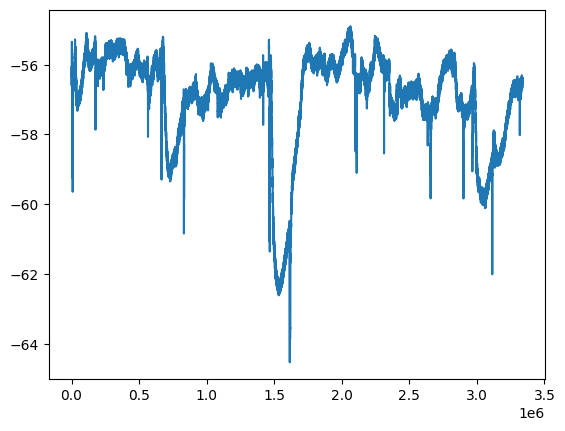

defaultdict(list,
            {'name': ['OxySoft Event'],
             'type': ['Event'],
             'channel_count': ['1'],
             'nominal_srate': ['0'],
             'channel_format': ['string'],
             'source_id': ['OxySoft'],
             'version': ['1.1000000000000001'],
             'created_at': ['82748.490747599993'],
             'uid': ['fb75806a-d17b-4dd4-8715-d8ece8332c29'],
             'session_id': ['default'],
             'hostname': ['WINDOWS-55O2M6R'],
             'v4address': [None],
             'v4data_port': ['16573'],
             'v4service_port': ['16573'],
             'v6address': [None],
             'v6data_port': ['16573'],
             'v6service_port': ['16573'],
             'desc': [None],
             'stream_id': 4,
             'effective_srate': 0})

In [6]:
for s in range(0, len(streams)):

    # OxySoft-fNIRS&EEG
    if streams[s]['info']['name'][0]=='OxySoft':
        print('Entroooo',s)
        # timeline
        oxy_timeline = streams[s]['time_stamps']
        # oxy_offset = streams[s]
        oxy_first_timestamp = streams[s]['time_stamps'][0]
        oxy_timeline = oxy_timeline - oxy_first_timestamp
        eeg_effective_srate = streams[s]['info']['effective_srate']


        # channel labels of EEG and fNIRS
        oxy_channel_data = streams[s]['info']['desc'][0]['channels'][0]['channel']

        # 18 channels EEG 43 channels fNIRS
        eeg_data = streams[s]['time_series'][:, 43:-1] * 1e-6 # convert the data to uV
        fnirs_data = streams[s]['time_series'][:, 0:44]
# //////////////////////////////////////////////////////////////////////////////
# Detect the events
s = 0
for s in range(0, len(streams)):

    # OxySoft-events
    if streams[s]['info']['name'][0]=='reiz-marker':
        print('Entroooo 2')
        # onset time of events
        events_time = streams[s]['time_stamps'] - oxy_first_timestamp

        # events
        events = streams[s]['time_series']
        events = [x for list in events for x in list]
# events_time
# streams[s]['info']
# oxy_first_timestamp
# len(streams)
# streams[1]['time_stamps']
# # events_time
# # oxy_first_timestamp
events
print(events_time)
# %.............................................................................
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
print(fnirs_data.shape, fnirs_data[:,0])
plt.plot( fnirs_data[:,1] ) # plotting by columns
plt.show()
# print(eeg_data, len(eeg_data))

# print(streams[8]['time_stamps'])
# print(streams[8]['time_series'])
# print(eeg_data, len(eeg_data), eeg_data.shape)
streams[2]['info'] # buscar reiz-marker
                   #  Subject 1 : streams[2]['info']
                   #  Subject 3 : streams[3]['info']
                   #  Subject 4 : streams[2]['info']
                   #  Subject 5 : streams[3]['info']

In [7]:
for i in range(16):    
    if streams[s]['info']['name'][0]=='reiz-marker':
            print('Entroooo 2')
            # onset time of events
            events_time = streams[s]['time_stamps'] - oxy_first_timestamp

            # events
            events = streams[s]['time_series']
            events = [x for list in events for x in list]
print(events_time)

[  10.2942027   20.0373439  369.8263858  512.544396   861.5658272
 1095.6574995 1109.2023131 1288.4849624 1296.9255994 1395.9572299
 1697.8733547 1706.764705 ]


In [8]:
print(streams[3]['time_series'])
print(events_time)

[[ 8.9369900e+06  2.0690000e+03  2.0500000e+03 ...  6.4000000e+02
   2.2000000e+02 -1.7180000e+04]
 [ 8.9373170e+06  2.0680000e+03  2.0500000e+03 ...  6.4800000e+02
   1.9600000e+02 -1.7260000e+04]
 [ 8.9376440e+06  2.0670000e+03  2.0510000e+03 ...  6.1600000e+02
   1.8400000e+02 -1.7264000e+04]
 ...
 [ 1.4820566e+07  2.0660000e+03  2.0500000e+03 ...  5.8800000e+02
   1.6800000e+02 -1.7276000e+04]
 [ 1.4820893e+07  2.0680000e+03  2.0480000e+03 ...  5.8400000e+02
   1.6400000e+02 -1.7308000e+04]
 [ 1.4821220e+07  2.0700000e+03  2.0500000e+03 ...  5.9600000e+02
   1.4400000e+02 -1.7292000e+04]]
[  10.2942027   20.0373439  369.8263858  512.544396   861.5658272
 1095.6574995 1109.2023131 1288.4849624 1296.9255994 1395.9572299
 1697.8733547 1706.764705 ]


In [9]:
print(oxy_first_timestamp)
print(oxy_timeline)
print(events_time)

3061.8070546999993
[0.0000000e+00 5.0000000e-04 1.0000000e-03 ... 1.7155385e+03 1.7155390e+03
 1.7155395e+03]
[  10.2942027   20.0373439  369.8263858  512.544396   861.5658272
 1095.6574995 1109.2023131 1288.4849624 1296.9255994 1395.9572299
 1697.8733547 1706.764705 ]


In [8]:
print(events)
print(oxy_timeline)
print(oxy_first_timestamp)
print(oxy_channel_data)

print(eeg_data.shape)
# events[6] ='complete_n-1_back';
print(events)

['session_start', 'start_task-1', 'complete_task-1', 'start_task-2', 'start_n-2_back', 'complete_n-2_back', 'complete_task-2', 'start_task-4', 'complete_task-4', 'start_task-3', 'complete_task-3', 'session_complete']
[0.00000000e+00 4.99999995e-04 1.00000000e-03 ... 1.66851850e+03
 1.66851900e+03 1.66851950e+03]
82771.19711480004
[defaultdict(<class 'list'>, {'label': ['[24024] Rx1-Tx1 O2Hb'], 'unit': ['umol'], 'type': ['NIRS'], 'location': [defaultdict(<class 'list'>, {'X': ['0'], 'Y': ['0'], 'Z': ['0']})]}), defaultdict(<class 'list'>, {'label': ['[24024] Rx1-Tx1 HHb'], 'unit': ['umol'], 'type': ['NIRS'], 'location': [defaultdict(<class 'list'>, {'X': ['0'], 'Y': ['0'], 'Z': ['0']})]}), defaultdict(<class 'list'>, {'label': ['[24024] Rx1-Tx2 O2Hb'], 'unit': ['umol'], 'type': ['NIRS'], 'location': [defaultdict(<class 'list'>, {'X': ['0'], 'Y': ['0'], 'Z': ['0']})]}), defaultdict(<class 'list'>, {'label': ['[24024] Rx1-Tx2 HHb'], 'unit': ['umol'], 'type': ['NIRS'], 'location': [default

In [11]:
print(streams[3]['time_series'])
print(events)

[[ 8.9369900e+06  2.0690000e+03  2.0500000e+03 ...  6.4000000e+02
   2.2000000e+02 -1.7180000e+04]
 [ 8.9373170e+06  2.0680000e+03  2.0500000e+03 ...  6.4800000e+02
   1.9600000e+02 -1.7260000e+04]
 [ 8.9376440e+06  2.0670000e+03  2.0510000e+03 ...  6.1600000e+02
   1.8400000e+02 -1.7264000e+04]
 ...
 [ 1.4820566e+07  2.0660000e+03  2.0500000e+03 ...  5.8800000e+02
   1.6800000e+02 -1.7276000e+04]
 [ 1.4820893e+07  2.0680000e+03  2.0480000e+03 ...  5.8400000e+02
   1.6400000e+02 -1.7308000e+04]
 [ 1.4821220e+07  2.0700000e+03  2.0500000e+03 ...  5.9600000e+02
   1.4400000e+02 -1.7292000e+04]]
['session_start', 'start_task-3', 'complete_task-3', 'start_task-4', 'complete_task-4', 'start_task-2', 'start_n-2_back', 'complete_n-2_back', 'complete_task-2', 'start_task-1', 'complete_task-1', 'session_complete']


In [13]:
# Mapping the event label to unique event number
# oxy_events_dct = {'A: Start/session':1,
#              'B: End/session':2,
#              # 'C: Start/rest':3,
#              #  'D: End/rest':4,
#               'E: Start/task1':5,
#               'F: End/task1':6,
#               'G: Start/task2':7,
#               'H: End/task2':8,
#               'I: Start/task3':9,
#               'J: End/task3':10,
#               'K: Start/task4':11,
#               'L: End/task4': 12,
#               'M: Error/drop_peg':13,
#               'N: Error/handling_failure':14,
#               'O: Error/calculation_failure':15,
#               'P: Second_round':16}
# ..............................................................................
#  The list order shown below is based on Subject #2
oxy_events_dct = {'session_start':1,
              'session_complete':2,
              'start_n-2_back':3,
              'complete_n-2_back':4,
              'start_n-0_back':5,
              'complete_n-0_back':6,
              'start_n-1_back':7,
              'complete_n-1_back':8,
              'start_n-3_back':9,
              'complete_n-3_back': 10,
              'start_control':11,
              'complete_control':12,
              'start_question':13,
              'complete_question':14,
              'start_answer':15,
              'complete_answer':16}
# ..............................................................................

print(oxy_events_dct)

int_events_label = [oxy_events_dct[k_i] for k_i in events]
print(int_events_label)
shimmer_events_dct = {1: 'session_start',
              2: 'session_complete',
              3: 'start_n-2_back',
              4: 'complete_n-2_back',
              5: 'start_n-0_back',
              6: 'complete_n-0_back',
              7: 'start_n-1_back',
              8: 'complete_n-1_back',
              9: 'start_n-3_back',
              10: 'complete_n-3_back',
              11: 'start_control',
              12: 'complete_control',
              13: 'start_question',
              14: 'complete_question',
              15: 'start_answer',
              16: 'complete_answer'}
# ------------------------------------------------------------------------------
# shimmer_events_dct = {1: 'Start/session',
#                   2: 'End/session',
#                   5: 'Start/task1',
#                   6: 'End/task1',
#                   7: 'Start/task2',
#                   8: 'End/task2',
#                   9: 'Start/task3',
#                   10: 'End/task3',
#                   11: 'Start/task4',
#                   12: 'End/task4',
#                   13: 'Error/drop_peg',
#                   14: 'Error/handling_failure',
#                   15: 'Error/calculation_failure',
#                   16: 'Second_round'}
# ..............................................................................
# =======
str_events_label = [shimmer_events_dct[k_s] for k_s in int_events_label]
# print(int_events_label)


# find the nearest corresponding timestamp in the shimmer sensor time line
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or abs(value - array[idx-1]) < abs(value - array[idx])):
        return array[idx-1]
    else:
        return array[idx] 

{'session_start': 1, 'session_complete': 2, 'start_n-2_back': 3, 'complete_n-2_back': 4, 'start_n-0_back': 5, 'complete_n-0_back': 6, 'start_n-1_back': 7, 'complete_n-1_back': 8, 'start_n-3_back': 9, 'complete_n-3_back': 10, 'start_control': 11, 'complete_control': 12, 'start_question': 13, 'complete_question': 14, 'start_answer': 15, 'complete_answer': 16}


KeyError: 'None'

In [14]:
events

['session_start',
 'start_task-3',
 'complete_task-3',
 'start_task-2',
 'start_n-2_back',
 'complete_n-2_back',
 'complete_task-2',
 'start_task-4',
 'complete_task-4',
 'start_task-1',
 'complete_task-1',
 'session_complete']

In [15]:
oxy_timeline_df = pd.DataFrame({'eeg_lsl_timestamp': oxy_timeline})
oxy_timeline_df

,eeg_lsl_timestamp
0,0.0000
1,0.0005
2,0.0010
3,0.0015
4,0.0020
...,...
4734955,2367.4775
4734956,2367.4780
4734957,2367.4785
4734958,2367.4790


In [15]:
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or abs(value - array[idx-1]) < abs(value - array[idx])):
        return array[idx-1]
    else:
        return array[idx] 


for s in range(0, len(streams)):

    # OxySoft-fNIRS&EEG
    if streams[s]['info']['name'][0]=='OxySoft':

        # timeline
        oxy_timeline = streams[s]['time_stamps']
        # oxy_offset = streams[s]
        oxy_first_timestamp = streams[s]['time_stamps'][0]
        oxy_timeline = oxy_timeline - oxy_first_timestamp

for s in range(0, len(streams)):

    # OxySoft-events
    if streams[s]['info']['name'][0]=='reiz-marker':
        print('Entroooo 2')
        # onset time of events
        events_time = streams[s]['time_stamps'] - oxy_first_timestamp

        # events
        events = streams[s]['time_series']
        events = [x for list in events for x in list]
# events_time
oxy_timeline_df = pd.DataFrame({'eeg_lsl_timestamp': oxy_timeline})
oxy_timeline_df

eeg_event_index = np.zeros(len(events_time))
n = 0
for o_g in events_time:
    t_g = find_nearest(oxy_timeline_df['eeg_lsl_timestamp'], o_g)
    eeg_event_index[n] = oxy_timeline_df[oxy_timeline_df['eeg_lsl_timestamp'] == t_g].index.values[0]
    n = n + 1

print(events_time)
print(eeg_event_index)

Entroooo 2
[ 137.7186481  309.1009537  488.6248389  628.6613675  808.6638088
  813.1595124 1341.4877883 1358.7573918 1538.5000277 1726.3072496
 1905.5915864 2087.6993011 2123.739105  2123.8405749 2302.9055094
 2836.8443824]
[ 275437.  618202.  977250. 1257323. 1617328. 1626319. 2682976. 2717515.
 3077000. 3452614. 3811183. 4175399. 4247478. 4247681. 4605811. 5673689.]


In [16]:
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or abs(value - array[idx-1]) < abs(value - array[idx])):
        return array[idx-1]
    else:
        return array[idx] 


for s in range(0, len(streams)):

    # OxySoft-fNIRS&EEG
    if streams[s]['info']['name'][0]=='ShimmerECG':

        # timeline
        oxy_timeline = streams[s]['time_stamps']
        # oxy_offset = streams[s]
        oxy_first_timestamp = streams[s]['time_stamps'][0]
        oxy_timeline = oxy_timeline - oxy_first_timestamp

for s in range(0, len(streams)):

    # OxySoft-events
    if streams[s]['info']['name'][0]=='reiz-marker':
        print('Entroooo 2')
        # onset time of events
        events_time = streams[s]['time_stamps'] - oxy_first_timestamp

        # events
        events = streams[s]['time_series']
        events = [x for list in events for x in list]
# events_time
oxy_timeline_df = pd.DataFrame({'eeg_lsl_timestamp': oxy_timeline})
oxy_timeline_df

eeg_event_index = np.zeros(len(events_time))
n = 0
for o_g in events_time:
    t_g = find_nearest(oxy_timeline_df['eeg_lsl_timestamp'], o_g)
    eeg_event_index[n] = oxy_timeline_df[oxy_timeline_df['eeg_lsl_timestamp'] == t_g].index.values[0]
    n = n + 1

print(eeg_event_index)


Entroooo 2
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [18]:
# find the event index
eeg_event_index = np.zeros(len(events_time))
n = 0
for o_g in events_time:
    t_g = find_nearest(oxy_timeline_df['eeg_lsl_timestamp'], o_g)
    eeg_event_index[n] = oxy_timeline_df[oxy_timeline_df['eeg_lsl_timestamp'] == t_g].index.values[0]
    n = n + 1
df_eeg = pd.DataFrame({'label': str_events_label,
                          'index': eeg_event_index})


In [19]:
print(str_events_label)
print(eeg_event_index)

['session_start', 'start_n-2_back', 'complete_n-2_back', 'start_n-0_back', 'complete_n-0_back', 'start_n-1_back', 'complete_n-1_back', 'start_n-3_back', 'complete_n-3_back', 'start_control', 'complete_control', 'start_question', 'complete_question', 'start_answer', 'complete_answer', 'session_complete']
[1123030. 1123030. 1123030. 1123030. 1123030. 1123030. 1123030. 1123030.
 1123030. 1123030. 1123030. 1123030. 1123030. 1123030. 1123030. 1123030.]


In [20]:
eeg_event_index

array([1123030., 1123030., 1123030., 1123030., 1123030., 1123030.,
       1123030., 1123030., 1123030., 1123030., 1123030., 1123030.,
       1123030., 1123030., 1123030., 1123030.])

In [21]:
# generate the duration

eeg_duration = np.zeros(len(events))
n_g = 0

for event in df_eeg['label']:

    if event == 'Start/task1':
        eeg_duration[n_g] = df_eeg['index'][df_eeg['label'] == event].values - df_eeg['index'][
            df_eeg['label'] == 'End/task1'].values

    elif event == 'Start/task2':
        eeg_duration[n_g] = df_eeg['index'][df_eeg['label'] == event].values - df_eeg['index'][
            df_eeg['label'] == 'End/task2'].values

    elif event == 'Start/task3':
        eeg_duration[n_g] = df_eeg['index'][df_eeg['label'] == event].values - df_eeg['index'][
            df_eeg['label'] == 'End/task3'].values

    elif event == 'Start/task4':
        eeg_duration[n_g] = df_eeg['index'][df_eeg['label'] == event].values - df_eeg['index'][
            df_eeg['label'] == 'End/task4'].values

    elif event == 'Start/session':
        eeg_duration[n_g] = df_eeg['index'][df_eeg['label'] == event].values - df_eeg['index'][
            df_eeg['label'] == 'End/session'].values
    n_g = n_g + 1

eeg_duration = list(map(lambda x: -x / eeg_effective_srate, eeg_duration))


eeg_event_index

array([1123030., 1123030., 1123030., 1123030., 1123030., 1123030.,
       1123030., 1123030., 1123030., 1123030., 1123030., 1123030.,
       1123030., 1123030., 1123030., 1123030.])

In [7]:
################################################################################
####################  EEG  #####################################################
################################################################################

# Generate channels
eeg_channels_to_show = 18 # number of channel <= 18
eeg_channels = []

for m in list(range(eeg_channels_to_show)):
    eeg_channels.append(oxy_channel_data[m+44]['label'][0])
eeg_channels.insert(eeg_channels_to_show + 1, 'stimulus')

# Both are corrected the result to 3 decimal places
oxy_events_data = {'Onset': list(np.round(events_time, 3)),
               'Label': [1,2,3,4,5,6,7,8,9,10,11,12]}
a = pd.DataFrame(oxy_events_data)
b = pd.DataFrame(np.round(oxy_timeline, 3), columns=['Time'])

# initialise Stimulus signal
c = np.zeros(len(eeg_data))
z = 0

# find the index of event onset time in the time line
for i in a['Onset']:
    if (b['Time']==i).bool:
        events_index = b[b['Time']==i].index.values
        c[events_index] = a['Label'].iloc[z]
        z = z+1

# add the stimulus signal to the EEG data
eeg_stim_data = np.append(eeg_data[:, 0:eeg_channels_to_show], c.reshape(-1, 1), axis=1)


# Create Raw data Info
eog_channels_to_show = 2
# channel_types = list(('eog',) * eog_channels_to_show +
#                      ('eeg',) * (eeg_channels_to_show - eog_channels_to_show) +
#                      ('stim',))

# # EOG channel FPZ, Fp2
# channel_types = list(('eeg',) +
#                      ('eog',) +
#                      ('eeg',) * 12 +
#                      ('eog',) +
#                      ('eeg',) * 3 +
#                      ('stim',))

# # EOG channel FPZ
# channel_types = list(('eeg',) * 14 +
#                      ('eog',) +
#                      ('eeg',) * 3 +
#                      ('stim',))


# EOG channel Fp1, Fp2
channel_types = list(('eog',) * 2 +
                     ('eeg',) * 16 +
                     ('stim',))


eeg_channel_names = ['Fp1', 'Fp2', # eeg channels for eog artifacts detection
                     'F7', 'F8', 'F3', 'F4', 'FC5', 'FC6', 'T7', 'T8', 'P7', 'P8', 'O1', 'O2', 'Fpz', 'AFz', 'Fz', 'Cz',
                     'stimulus']

# Needs change here
eeg_channel_name_list = ['Fp1', 'Fp2', # eeg channels for eog artifacts detection
                     'F7', 'F8', 'F3', 'F4', 'FC5', 'FC6', 'T7', 'T8', 'P7', 'P8', 'O1', 'O2', 'AFz', 'Fz', 'Cz']


raw_eeg_info = mne.create_info(ch_names=eeg_channel_names,
                           sfreq=1000,
                           ch_types=channel_types)

raw_eeg_info.set_montage('standard_1020')
# Note the new field dig that includes our seven channel locations
# as well as theoretical values for the three cardinal scalp landmarks.


# Modify the Info
raw_eeg_info['description'] = '18 channels EEG'


# mark bad channels
raw_eeg_info['bads'] = ['Fp1', 'P7']# Names of bad channels

# raw_eeg_info['bads'].extend(['T7', 'P8'])# add a single channel
# bad_chan = raw.info['bads'].pop(-1)  # remove the last entry in the list

# create raw eeg data object
raw_eeg_data = mne.io.RawArray(eeg_stim_data.T, raw_eeg_info, first_samp=0)

# bad channels interpolation
raw_eeg_data_interp = raw_eeg_data.interpolate_bads()

# setting reference
# use a single channel reference
# raw_eeg_data.set_eeg_reference(ref_channels=['Cz'])

# filtering
# basic filtering
filtered_eeg_data = raw_eeg_data_interp.filter(l_freq=0.1, h_freq=40)
# events
eeg_events = mne.find_events(raw_eeg_data, stim_channel='stimulus')

# label the stimulus
# eeg_event_dict = {
#     'Start/session':1,
#     'End/session':2,
#     # 'Start/rest':3,
#     # 'End/rest':4,
#     'Start/task1':5,
#     'End/task1':6,
#     'Start/task2':7,
#     'End/task2':8,
#     'Start/task3':9,
#     'End/task3':10,
#     'Start/task4':11,
#     'End/task4': 12,
#     'Error/drop_peg':13,
#     # 'Error/':14,
#     'Error/calculation_failure':15,
#     'Second_round':16
# }
eeg_event_dict = {'session_start':1,
              'session_complete':2,
              'start_n-2_back':3,
              'complete_n-2_back':4,
              'start_n-0_back':5,
              'complete_n-0_back':6,
              'start_n-1_back':7,
              'complete_n-1_back':8,
              'start_n-3_back':9,
              'complete_n-3_back':10,
              'start_control':11,
              'complete_control':12,
              'start_question':13,
              'complete_question':14,
              'start_answer':15,
              'complete_answer':16
  }
# ..............................................................................
eeg_event_dict

Creating RawArray with float64 data, n_channels=19, n_times=3337040
    Range : 0 ... 3337039 =      0.000 ...  3337.039 secs
Ready.
Interpolating bad channels
    Automatic origin fit: head of radius 94.0 mm
Computing interpolation matrix from 15 sensor positions
Interpolating 1 sensors


C:\Users\W.K Li\AppData\Local\Temp\ipykernel_16052\2664884201.py:74: RuntimeWarning: Not setting positions of 2 eog channels found in montage:
['Fp1', 'Fp2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw_eeg_info.set_montage('standard_1020')


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (33.001 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    2.7s finished


12 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12]


{'session_start': 1,
 'session_complete': 2,
 'start_n-2_back': 3,
 'complete_n-2_back': 4,
 'start_n-0_back': 5,
 'complete_n-0_back': 6,
 'start_n-1_back': 7,
 'complete_n-1_back': 8,
 'start_n-3_back': 9,
 'complete_n-3_back': 10,
 'start_control': 11,
 'complete_control': 12,
 'start_question': 13,
 'complete_question': 14,
 'start_answer': 15,
 'complete_answer': 16}

In [ ]:
# # events
# eeg_events = mne.find_events(c.reshape(-1, 1))

In [13]:
eeg_events

array([[  20587,       0,       1],
       [  40073,       0,       2],
       [ 739651,       0,       3],
       [1025087,       0,       4],
       [1723131,       0,       5],
       [2191313,       0,       6],
       [2218403,       0,       7],
       [2576969,       0,       8],
       [2593851,       0,       9],
       [2791913,       0,      10],
       [3395745,       0,      11],
       [3413529,       0,      12]], dtype=int64)

C:\Users\W.K Li\AppData\Local\Temp\ipykernel_93172\419441234.py:16: MatplotlibDeprecationWarning: The span_where function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use fill_between instead.
  collection = collections.BrokenBarHCollection.span_where(
C:\Users\W.K Li\AppData\Local\Temp\ipykernel_93172\419441234.py:16: MatplotlibDeprecationWarning: The BrokenBarHCollection class was deprecated in Matplotlib 3.7 and will be removed two minor releases later.
  collection = collections.BrokenBarHCollection.span_where(
C:\Users\W.K Li\AppData\Local\Temp\ipykernel_93172\419441234.py:20: MatplotlibDeprecationWarning: The span_where function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use fill_between instead.
  collection = collections.BrokenBarHCollection.span_where(
C:\Users\W.K Li\AppData\Local\Temp\ipykernel_93172\419441234.py:20: MatplotlibDeprecationWarning: The BrokenBarHCollection class was deprecated in Matplotlib 

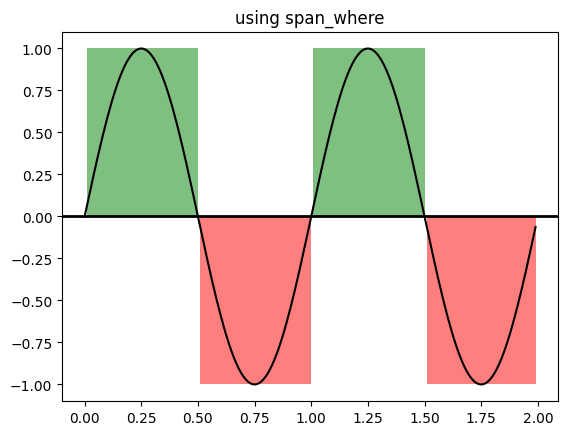

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as collections


t = np.arange(0.0, 2, 0.01)
s1 = np.sin(2*np.pi*t)
s2 = 1.2*np.sin(4*np.pi*t)


fig, ax = plt.subplots()
ax.set_title('using span_where')
ax.plot(t, s1, color='black')
ax.axhline(0, color='black', lw=2)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=0, ymax=1, where=s1 > 0, facecolor='green', alpha=0.5)
ax.add_collection(collection)

collection = collections.BrokenBarHCollection.span_where(
    t, ymin=-1, ymax=0, where=s1 < 0, facecolor='red', alpha=0.5)
ax.add_collection(collection)


plt.show()

Using matplotlib as 2D backend.


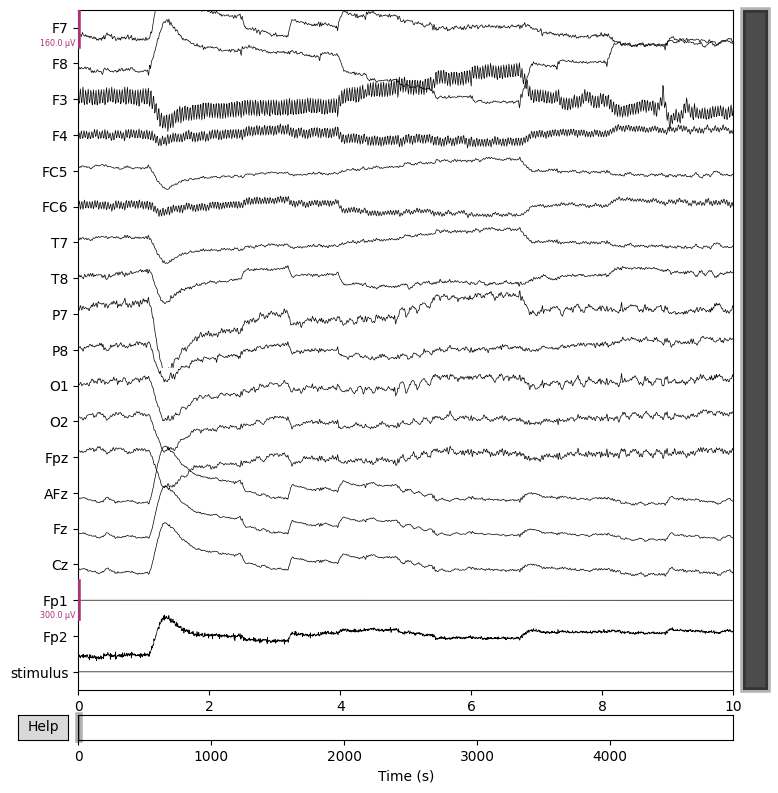

4926080


In [24]:
eeg_channel_name_list
filtered_eeg_data.plot(events=eeg_events, event_id=eeg_event_dict, scalings=dict(eeg=80e-6))
print(len(filtered_eeg_data))

In [18]:
# /content/drive/MyDrive/Gall_Bladder_Study/Output_files
print(len(filtered_eeg_data))
# scipy.io.savemat('/content/drive/MyDrive/Maestro_ML/EEG/Data_First_Experiment/filtered_eeg_data.mat', {'filtere_EEGdata': filtered_eeg_data})
print(type(filtered_eeg_data))
filtered_signals = filtered_eeg_data.get_data()

4734960
<class 'mne.io.array.array.RawArray'>


In [26]:
# Data processing of Fnirs data
fnirs_data.shape
fnirsChannelsNames = ["channel"+str(i) for i in range(44)]
typeChannels = ['hbo', 'hbr', 'hbo', 'hbr',
                'hbo', 'hbr', 'hbo', 'hbr',
                'hbo', 'hbr', 'hbo', 'hbr',
                'hbo', 'hbr', 'hbo', 'hbr',
                'hbo', 'hbr', 'hbo', 'hbr',
                'hbo', 'hbr', 'hbo', 'hbr',
                'hbo', 'hbr', 'hbo', 'hbr',
                'hbo', 'hbr', 'hbo', 'hbr',
                'hbo', 'hbr', 'hbo', 'hbr',
                'hbo', 'hbr', 'hbo', 'hbr','hbo', 'hbr', 'hbo','hbr']
raw_eeg_info = mne.create_info(ch_names=fnirsChannelsNames,
                           sfreq=1000,
                           ch_types=typeChannels)
Raw_fnirs_data = mne.io.RawArray(fnirs_data.T, raw_eeg_info, first_samp=0)



Creating RawArray with float64 data, n_channels=44, n_times=4926080
    Range : 0 ... 4926079 =      0.000 ...  4926.079 secs
Ready.


In [27]:
prepFnirsData = Raw_fnirs_data.get_data()

In [19]:
prepFnirsData = prepFnirsData.T
prepFnirsData.shape

NameError: name 'prepFnirsData' is not defined

In [30]:
import csv

filename1 = "G:/Code_Multimodal_Deep_learning/Data/Testing001/fNIRS/rawFnirs.csv"
with open(filename1, 'w', newline='') as csvfile:
    # creating a csv writer object
    csvwriter = csv.writer(csvfile)
     
    # writing the data rows
    csvwriter.writerows(prepFnirsData)

In [29]:
prepFnirsData.shape
dddddddddddd = pd.read_csv("G:/Code_Multimodal_Deep_learning/Data/Mydataset_p003/fNIRS/testingData/S003.csv", delimiter=',', header=None,)


In [31]:
filename1 = "G:/Code_Multimodal_Deep_learning/Data/Testing001/EEG/rawEEG.csv"
with open(filename1, 'w', newline='') as csvfile:
    # creating a csv writer object
    csvwriter = csv.writer(csvfile)
     
    # writing the data rows
    csvwriter.writerows(filtered_signals)

In [36]:
dddddddddddd.shape

(4926080, 44)

In [20]:
print(events[6])
# events[6] = 'complete_n-1_back'
# print(events[6])
print(streams[8]['time_series'])
eeg_event_index

None
[[ 0.11169868  0.78441855  1.28961929 ...         nan  3.18935271
          nan]
 [ 0.0967233   0.72313817  1.11695804 ...         nan  3.66653499
          nan]
 [ 0.16931564  0.65380099  1.09623812 ...         nan  2.96281396
          nan]
 ...
 [ 0.          1.07195179  0.34023957 ...         nan -0.06934144
          nan]
 [ 0.99        0.07697659  0.0898104  ... 30.55792785         nan
   2.4014664 ]
 [ 0.99        0.08033129  0.08952365 ... 30.22674857         nan
   2.39552724]]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [26]:
import scipy
print(filtered_signals.shape,filtered_signals)
scipy.io.savemat('G:/Code_Multimodal_Deep_learning/Data/Mydataset_p004/EEG/filtered_eeg_data_S0044.mat', {'filtered_eeg_signals_S004': filtered_signals})


(19, 4921080) [[-2.96447524e-05 -2.96447524e-05 -2.96447524e-05 ...  9.33571812e-07
   9.33571812e-07  9.33571812e-07]
 [-3.59269208e-03 -3.54960910e-03 -3.50637920e-03 ...  8.43880512e-03
   8.39701481e-03  8.34675506e-03]
 [-7.80625564e-18  3.02351790e-05  6.02593678e-05 ...  5.64909759e-05
   2.83727069e-05  3.25260652e-19]
 ...
 [ 5.20417043e-18  2.93161588e-05  5.84579945e-05 ...  5.46761241e-05
   2.74537785e-05  1.79570985e-19]
 [ 4.33680869e-19  2.90002463e-05  5.78446213e-05 ...  5.40052097e-05
   2.71154935e-05  5.42101086e-19]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [9]:
print(cal_emg_data['emg_ch1_cal_mv'].to_numpy().shape)
print(cal_ecg_data['ecg_la_ra_cal_mv'].to_numpy().shape)

(854176,)
(850072,)


In [10]:
print(fnirs_data.shape)
print(filtered_eeg_data.get_data().shape)

(3337040, 44)
(19, 3337040)


In [11]:
EEG_dataset = []
EEG_data = filtered_eeg_data.get_data()
for i in range(0, 3320000, 500):
    temp = []
    for j in range(18):
        temp.extend(EEG_data[j,i:i+500])
    EEG_dataset.append(temp)
print(len(EEG_dataset[0]))
print(len(EEG_dataset))
EEG_dataset = np.array(EEG_dataset)
print(EEG_dataset.shape)

9000
6640
(6640, 9000)


In [12]:
events
EEG_data.shape
fnirs_data.shape
fnirs_dataset = []
for i in range(0, 3320000, 500):
    temp = []
    for j in range(44):
        temp.extend(fnirs_data[i:i+500,j])
    fnirs_dataset.append(temp)

print(len(fnirs_dataset[0]))
print(len(fnirs_dataset))
fnirs_dataset = np.array(fnirs_dataset)
print(fnirs_dataset.shape)

22000
6640
(6640, 22000)


In [16]:
events_time
timeMarks2 = [ 39.6141137,  347.5713982,  526.8569288,  597.5687355, 777.3087525,  841.6554667, 1020.987244 , 1229.5489498, 1409.0733649, 1462.3059525, 1642.3096532, 1651.2573736, 1687.2964646, 1687.398796 , 1961.3391422, 2455.5089476]# subject 3
timeMarks2 = [ 137.7186481,  309.1009537,  488.6248389,  628.6613675,  808.6638088, 813.1595124, 1341.4877883, 1358.7573918, 1538.5000277, 1726.3072496, 1905.5915864, 2087.6993011, 2123.739105,  2123.8405749, 2302.9055094, 2836.8443824]# subject 1
timeMarks2 = [ 108.706262,   149.5254338,  329.5283403,  533.8484876,  713.1805047, 797.5706615,  976.8565046, 1117.7728496, 1297.5133921, 1451.7105547, 1631.2354289, 1969.811543,  2005.8502711, 2005.9676461, 2252.4441821, 2453.2866462]# subject 4
events
emgCh1 = cal_emg_data['emg_ch1_cal_mv'].to_numpy()[:1244672] # divisible by 512 sampling frequency
emgCh2 = cal_emg_data['emg_ch2_cal_mv'].to_numpy()[:1244672]
ecgCh1 = cal_ecg_data['ecg_la_ra_cal_mv'].to_numpy()[:1244672]
ecgCh2 = cal_ecg_data['ecg_ll_ra_cal_mv'].to_numpy()[:1244672]
part_size = 128
dataset = []
fdataset = []
for i in range(0, len(ecgCh1), part_size):
    part = np.concatenate((ecgCh1[i:i+part_size],ecgCh2[i:i+part_size],emgCh1[i:i+part_size],emgCh2[i:i+part_size]))
    dataset.append(part)
for i in range(0,len(dataset),4):
    index = i
    i = i/4
    if i >= timeMarks2[1] and i <= timeMarks2[2]:
        fdataset.append(np.concatenate((dataset[index],EEG_dataset[index],fnirs_dataset[index],[7])))
        fdataset.append(np.concatenate((dataset[index+1],EEG_dataset[index+1],fnirs_dataset[index+1],[7])))
        fdataset.append(np.concatenate((dataset[index+2],EEG_dataset[index+2],fnirs_dataset[index+2],[7])))
        fdataset.append(np.concatenate((dataset[index+3],EEG_dataset[index+3],fnirs_dataset[index+3],[7])))
    elif i >= timeMarks2[3] and i <= timeMarks2[4]:
        fdataset.append(np.concatenate((dataset[index],EEG_dataset[index],fnirs_dataset[index],[1])))
        fdataset.append(np.concatenate((dataset[index+1],EEG_dataset[index+1],fnirs_dataset[index+1],[1])))
        fdataset.append(np.concatenate((dataset[index+2],EEG_dataset[index+2],fnirs_dataset[index+2],[1])))
        fdataset.append(np.concatenate((dataset[index+3],EEG_dataset[index+3],fnirs_dataset[index+3],[1])))
    elif i >= timeMarks2[5] and i <= timeMarks2[6]:
        fdataset.append(np.concatenate((dataset[index],EEG_dataset[index],fnirs_dataset[index],[2])))
        fdataset.append(np.concatenate((dataset[index+1],EEG_dataset[index+1],fnirs_dataset[index+1],[2])))
        fdataset.append(np.concatenate((dataset[index+2],EEG_dataset[index+2],fnirs_dataset[index+2],[2])))
        fdataset.append(np.concatenate((dataset[index+3],EEG_dataset[index+3],fnirs_dataset[index+3],[2])))
    elif i >= timeMarks2[7] and i <= timeMarks2[8]:
        fdataset.append(np.concatenate((dataset[index],EEG_dataset[index],fnirs_dataset[index],[3])))
        fdataset.append(np.concatenate((dataset[index+1],EEG_dataset[index+1],fnirs_dataset[index+1],[3])))
        fdataset.append(np.concatenate((dataset[index+2],EEG_dataset[index+2],fnirs_dataset[index+2],[3])))
        fdataset.append(np.concatenate((dataset[index+3],EEG_dataset[index+3],fnirs_dataset[index+3],[3])))
    elif i >= timeMarks2[9] and i <= timeMarks2[10]:
        fdataset.append(np.concatenate((dataset[index],EEG_dataset[index],fnirs_dataset[index],[4])))
        fdataset.append(np.concatenate((dataset[index+1],EEG_dataset[index+1],fnirs_dataset[index+1],[4])))
        fdataset.append(np.concatenate((dataset[index+2],EEG_dataset[index+2],fnirs_dataset[index+2],[4])))
        fdataset.append(np.concatenate((dataset[index+3],EEG_dataset[index+3],fnirs_dataset[index+3],[4])))
    elif i >= timeMarks2[11] and i <= timeMarks2[12]:
        fdataset.append(np.concatenate((dataset[index],EEG_dataset[index],fnirs_dataset[index],[5])))
        fdataset.append(np.concatenate((dataset[index+1],EEG_dataset[index+1],fnirs_dataset[index+1],[5])))
        fdataset.append(np.concatenate((dataset[index+2],EEG_dataset[index+2],fnirs_dataset[index+2],[5])))
        fdataset.append(np.concatenate((dataset[index+3],EEG_dataset[index+3],fnirs_dataset[index+3],[5])))
    elif i >= timeMarks2[13] and i <= timeMarks2[14]:
        fdataset.append(np.concatenate((dataset[index],EEG_dataset[index],fnirs_dataset[index],[6])))
        fdataset.append(np.concatenate((dataset[index+1],EEG_dataset[index+1],fnirs_dataset[index+1],[6])))
        fdataset.append(np.concatenate((dataset[index+2],EEG_dataset[index+2],fnirs_dataset[index+2],[6])))
        fdataset.append(np.concatenate((dataset[index+3],EEG_dataset[index+3],fnirs_dataset[index+3],[6])))
    else:
        fdataset.append(np.concatenate((dataset[index],EEG_dataset[index],fnirs_dataset[index],[7])))
        fdataset.append(np.concatenate((dataset[index+1],EEG_dataset[index+1],fnirs_dataset[index+1],[7])))
        fdataset.append(np.concatenate((dataset[index+2],EEG_dataset[index+2],fnirs_dataset[index+2],[7])))
        fdataset.append(np.concatenate((dataset[index+3],EEG_dataset[index+3],fnirs_dataset[index+3],[7])))
print(fdataset[236])
np.savetxt('G:\Code_Multimodal_Deep_learning\Data\Testing004\All_Combine\Subject_4_EEG_fnirs_ECG_EMG_signal.csv', fdataset, delimiter=',')

[1.10692276 1.11824585 1.10136939 ... 0.32429561 0.32429561 7.        ]


In [13]:
emgCh1 = cal_emg_data['emg_ch1_cal_mv'].to_numpy()[:849920] # divisible by 512 sampling frequency
emgCh2 = cal_emg_data['emg_ch2_cal_mv'].to_numpy()[:849920]
ecgCh1 = cal_ecg_data['ecg_la_ra_cal_mv'].to_numpy()[:849920]
ecgCh2 = cal_ecg_data['ecg_ll_ra_cal_mv'].to_numpy()[:849920]
timeMarks = [ 5.5186809,   16.5049484,   48.42202,    227.7046816, 428.0950661,  560.5548623,  936.0304033, 1066.6885758, 1391.0576052, 1489.1214408, 2297.8068123, 2305.4956753]
timeMarks = [4.1427587,  19.0725375,  460.4203758,  686.1871592,  707.4059002, 886.68851,   1053.3925423, 1251.3892339, 1793.1197409, 1969.6637005, 2340.9209839, 2353.6824128]
timeMarks = [10.2942027  , 20.0373439,  369.8263858,  512.544396 ,  861.5658272, 1095.6574995 ,1109.2023131 ,1288.4849624 ,1296.9255994, 1395.9572299 ,1697.8733547 ,1706.764705 ]
timeMarks = [   7.8997112 ,  19.1775845 , 321.5772436 , 416.7572342,  434.2723157 ,613.5550813 , 698.2222233 , 946.3453544, 1324.4079284, 1424.2739369 ,1654.6673456 ,1660.5857678]
print(ecgCh1.shape)
print(emgCh1.shape)
part_size = 128
dataset = []
fdataset = []
for i in range(0, len(ecgCh1), part_size):
    part = np.concatenate((ecgCh1[i:i+part_size],ecgCh2[i:i+part_size],emgCh1[i:i+part_size],emgCh2[i:i+part_size]))
    dataset.append(part)
for i in range(0,len(dataset),4):
    index = i
    i = i/4
    if i >= timeMarks[1] and i <= timeMarks[2]:
        fdataset.append(np.concatenate((dataset[index],EEG_dataset[index],fnirs_dataset[index],[1])))
        fdataset.append(np.concatenate((dataset[index+1],EEG_dataset[index+1],fnirs_dataset[index+1],[1])))
        fdataset.append(np.concatenate((dataset[index+2],EEG_dataset[index+2],fnirs_dataset[index+2],[1])))
        fdataset.append(np.concatenate((dataset[index+3],EEG_dataset[index+3],fnirs_dataset[index+3],[1])))
    elif i >= timeMarks[3] and i <= timeMarks[6]:
        fdataset.append(np.concatenate((dataset[index],EEG_dataset[index],fnirs_dataset[index],[2])))
        fdataset.append(np.concatenate((dataset[index+1],EEG_dataset[index+1],fnirs_dataset[index+1],[2])))
        fdataset.append(np.concatenate((dataset[index+2],EEG_dataset[index+2],fnirs_dataset[index+2],[2])))
        fdataset.append(np.concatenate((dataset[index+3],EEG_dataset[index+3],fnirs_dataset[index+3],[2])))
    elif i >= timeMarks[7] and i <= timeMarks[8]:
        fdataset.append(np.concatenate((dataset[index],EEG_dataset[index],fnirs_dataset[index],[4])))
        fdataset.append(np.concatenate((dataset[index+1],EEG_dataset[index+1],fnirs_dataset[index+1],[4])))
        fdataset.append(np.concatenate((dataset[index+2],EEG_dataset[index+2],fnirs_dataset[index+2],[4])))
        fdataset.append(np.concatenate((dataset[index+3],EEG_dataset[index+3],fnirs_dataset[index+3],[4])))
    elif i >= timeMarks[9] and i <= timeMarks[10]:
        fdataset.append(np.concatenate((dataset[index],EEG_dataset[index],fnirs_dataset[index],[3])))
        fdataset.append(np.concatenate((dataset[index+1],EEG_dataset[index+1],fnirs_dataset[index+1],[3])))
        fdataset.append(np.concatenate((dataset[index+2],EEG_dataset[index+2],fnirs_dataset[index+2],[3])))
        fdataset.append(np.concatenate((dataset[index+3],EEG_dataset[index+3],fnirs_dataset[index+3],[3])))
    else:
        fdataset.append(np.concatenate((dataset[index],EEG_dataset[index],fnirs_dataset[index],[5])))
        fdataset.append(np.concatenate((dataset[index+1],EEG_dataset[index+1],fnirs_dataset[index+1],[5])))
        fdataset.append(np.concatenate((dataset[index+2],EEG_dataset[index+2],fnirs_dataset[index+2],[5])))
        fdataset.append(np.concatenate((dataset[index+3],EEG_dataset[index+3],fnirs_dataset[index+3],[5])))
print(fdataset[236])
np.savetxt('G:\Code_Multimodal_Deep_learning\Data\Testing010\All_Combine\Subject_5_ECG_EMG_signalsAllMydata.csv', fdataset, delimiter=',')

(849920,)
(849920,)
[4.83481763 4.82883153 4.85436259 ... 1.53318822 1.53318822 1.        ]
